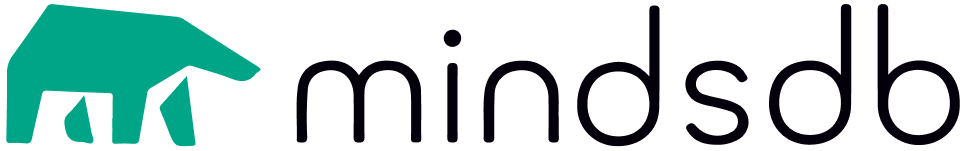

[MindsDB](https://github.com/mindsdb/mindsdb) is the platform for customizing AI from enterprise data. With MindsDB and its nearly 200 integrations to data sources and AI/ML frameworks, any developer can deploy, serve, and fine-tune models in real-time, and build AI-powered applications.

[MindsDB integrates with OpenAI](https://docs.mindsdb.com/integrations/ai-engines/openai), enabling users to deploy, serve, and fine-tune OpenAI models within MindsDB, making them accessible to numerous data sources.

In this example we are going to teach an OpenAI model, how to write MindsDB AI SQL queries

## Prerequisites
Before proceeding, ensure the following prerequisites are met:

- Install MindsDB locally via [Docker.](https://docs.mindsdb.com/setup/self-hosted/docker)
- Obtain the OpenAI API key required to deploy and use OpenAI models within MindsDB.

## Setup

MindsDB provides the [OpenAI handler](https://github.com/mindsdb/mindsdb/tree/staging/mindsdb/integrations/handlers/openai_handler) that enables you to create OpenAI models within MindsDB.

## AI Engine

Before creating a model, it is required to create an AI engine based on the provided handler.

In [ ]:
CREATE ML_ENGINE openai_engine
FROM openai
USING
    openai_api_key = 'your-openai-api-key';

## AI Model

Then, create a model to answer questions about MindsDB’s custom SQL syntax using this engine:

In [ ]:
CREATE MODEL openai_davinci
PREDICT completion
USING
    engine = 'openai_engine',
    model_name = 'davinci-002',
    prompt_template = 'Return a valid SQL string for the following question about MindsDB in-database machine learning: {{prompt}}';

You can check model status with this command:

In [ ]:
DESCRIBE openai_davinci;

Once the status is complete, we can query for predictions:

In [ ]:
SELECT prompt, completion
FROM openai_davinci as m
WHERE prompt = 'What is the SQL syntax to join input data with predictions from a MindsDB machine learning model?'
USING max_tokens=400;

On execution, we get:

In [ ]:
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| prompt                                                                                            | completion                                                                                           |
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| What is the SQL syntax to join input data with predictions from a MindsDB machine learning model? | The SQL syntax is: SELECT * FROM input_data INNER JOIN predictions ON input_data.id = predictions.id |
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+

## Finetune Model

Now, we’ll fine-tune our model using a table that stores details about MindsDB’s custom SQL syntax.

[Upload](https://docs.mindsdb.com/mindsdb_sql/sql/create/file) this [dataset](https://github.com/mindsdb/mindsdb/blob/staging/docs/use-cases/automated_finetuning/data.csv) as a file which you can use as a table.

In [ ]:
FINETUNE openai_davinci
FROM files
    (SELECT prompt, completion FROM openai_learninghub_ft);

The `FINETUNE` command creates a new version of the openai_davinci model. You can query all available versions as below:

In [ ]:
SELECT *
FROM models_versions
WHERE name = 'openai_davinci';

Once the new version status is complete and active, we can query the model again, expecting a more accurate output.

In [ ]:
SELECT prompt, completion
FROM openai_davinci as m
WHERE prompt = 'What is the SQL syntax to join input data with predictions from a MindsDB machine learning model?'
USING max_tokens=400;

On execution you get:

In [ ]:
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| prompt                                                                                            | completion                                                                                           |
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| What is the SQL syntax to join input data with predictions from a MindsDB machine learning model? | SELECT * FROM mindsdb.models.my_model JOIN mindsdb.input_data_name;                                  |
+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+

If you have dynamic data that gets updated regularly, you can set up an automated fine-tuning as below.

Note that the data source must contain an incremental column, such as timestamp or integer, so MindsDB can pick up only the recently added data.

Create a view to store recently added data with the help of the `LAST` keyword:

In [ ]:
CREATE VIEW recent_data (
    SELECT *
    FROM files.openai_learninghub_ft
    WHERE timestamp > LAST
);

Create a job to fine-tune the model periodically.

In [ ]:
CREATE JOB automated_finetuning (

    FINETUNE openai_davinci
    FROM mindsdb
        (SELECT * FROM recent_data)
)
EVERY 1 day;

Now your model will be fine-tuned with newly added data every day.

See below more Usecases:

- [Text Summarization with MindsDB and OpenAI using SQL](https://docs.mindsdb.com/use-cases/data_enrichment/text-summarization-inside-mysql-with-openai)
- [Sentiment Analysis with MindsDB and OpenAI using SQL](https://docs.mindsdb.com/use-cases/data_enrichment/sentiment-analysis-inside-mysql-with-openai)
- [Question Answering with MindsDB and OpenAI using SQL](https://docs.mindsdb.com/use-cases/data_enrichment/question-answering-inside-mysql-with-openai)
- [Extract JSON from Text](https://docs.mindsdb.com/use-cases/data_enrichment/json-from-text)
- [Text Summarization with MindsDB and OpenAI using MQL](https://docs.mindsdb.com/use-cases/data_enrichment/text-summarization-inside-mongodb-with-openai)
- [Sentiment Analysis with MindsDB and OpenAI using MQL](https://docs.mindsdb.com/use-cases/data_enrichment/sentiment-analysis-inside-mongodb-with-openai)
- [Question Answering with MindsDB and OpenAI using MQL](https://docs.mindsdb.com/use-cases/data_enrichment/question-answering-inside-mongodb-with-openai)

Follow MindsDB's [OpenAI documentation](https://docs.mindsdb.com/integrations/ai-engines/openai) for more information.